##Project: Automatic Waste Segregator -

This project is a part of my Deputy Coordinator tenure from November, 2023 to May, 2024 in Sahaay Social Innovation Club at IIT Madras.

The objective is to design an image classification system using pre-trained MobileNet architecture which is capable of automatically sorting waste items into six distinct classes based on their material type: glass, metal, paper, wood, plastic and mixed. The 'mixed' class also holds other types of waste. The ultimate goal is to integrate this into a physical waste bin system in an effort to improve recycling efficiency and waste management.

(Note: The dataset used for this project was made my team in the Sahaay Club and details regarding it's external use can be found in its github repository.)

(Also the current outputs of each cell correspond to the final iteration of the model.)

In [ ]:
# Import the dataset

!git clone https://github.com/RishiNandha/AWS_Dataset

Cloning into 'AWS_Dataset'...
remote: Enumerating objects: 5414, done.
remote: Counting objects: 100% (1473/1473), done.
remote: Compressing objects: 100% (1457/1457), done.
remote: Total 5414 (delta 19), reused 1468 (delta 16), pack-reused 3941
Receiving objects: 100% (5414/5414), 93.88 MiB | 15.08 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (5340/5340), done.


In [ ]:
# Import necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory as image_dataset
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, F1Score, AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report



In [ ]:
# Setting path to training data

os.chdir('AWS_Dataset')

In [ ]:
data_dir = '/content/AWS_Dataset/Dataset'

###Data loading:

In [ ]:
# Variables

batch_size = 32
img_size = (224, 224) # Recommended for MobileNet
validation_split = 0.3
val_test_split_denom = 2 # denom in fraction of val_set to be used for testing (f: 1/f )
# We'll do 70/15/15 split

In [ ]:
train_df = image_dataset(
    data_dir,
    validation_split = validation_split,
    subset = 'training',
    seed = 420,
    image_size = img_size,
    batch_size = batch_size
)

val_df = image_dataset(
    data_dir,
    validation_split = validation_split,
    subset = 'validation',
    seed = 420,
    image_size = img_size,
    batch_size = batch_size
)

Found 5327 files belonging to 6 classes.
Using 3729 files for training.
Found 5327 files belonging to 6 classes.
Using 1598 files for validation.


These are class labels.

In [ ]:
# Creating test set from val set

val_batches = tf.data.experimental.cardinality(val_df)
test_df = val_df.take(val_batches // val_test_split_denom) # keep 20%
val_df = val_df.skip(val_batches // val_test_split_denom)

###Understanding the data:



In [ ]:
# Find the number of classes and class categories

class_names = train_df.class_names
num_classes = len(class_names)
print(num_classes)
print(class_names)

6
['glass', 'metal', 'mixed', 'paper', 'plastic', 'wood']


In [ ]:
# Find number of images in each class

for class_name in class_names:
  class_path = os.path.join(data_dir, class_name)
  num_images = len(os.listdir(class_path))
  print(f'Number of images in class: {class_name} is {num_images}.')

Number of images in class: glass is 966.
Number of images in class: metal is 784.
Number of images in class: mixed is 759.
Number of images in class: paper is 1283.
Number of images in class: plastic is 714.
Number of images in class: wood is 832.


The data amongst classes is somewhat balanced. Ensures no significant bias due to class imbalance.

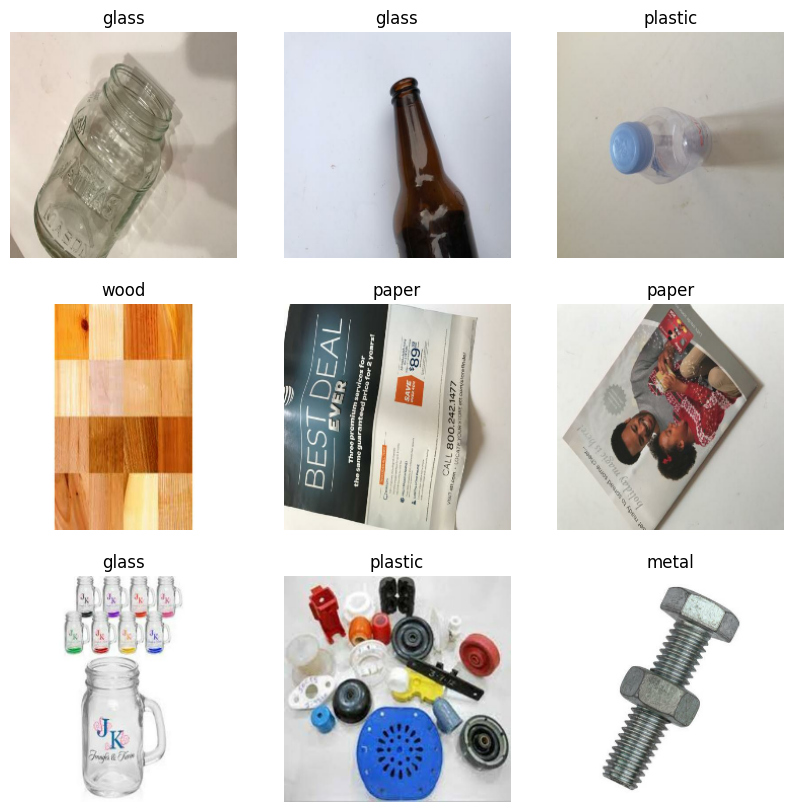

In [ ]:
# Visualise the data

plt.figure(figsize = (10,10))
for images, labels in train_df.take(1): # fetch 1 batch
  for i in range(9): # first 9 images
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(images[i].numpy().astype('uint8'))
    ax.set_title(class_names[labels[i]])
    ax.axis('off')

In [ ]:
# Identify sizes
for image_batch, label_batch in train_df:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 224, 224, 3)
(32,)


Note: The size is in channel first format.

###Data Preprocessing:


In [ ]:
# One hot encode labels

def one_hot_encode(image, label):
  label = tf.one_hot(label, depth = 6) # Number of classes = 6
  return image, label


In [ ]:
train_df = train_df.map(one_hot_encode)
val_df = val_df.map(one_hot_encode)

In [ ]:
# Configure dataset for optimal performance

AUTOTUNE = tf.data.AUTOTUNE # automatically finds best parameters

train_df = train_df.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE) # Assuming buffer size of 1000 for shuffling
val_df = train_df.cache().prefetch(buffer_size = AUTOTUNE)
test_df = test_df.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
# Data augmentation

data_augmentation = tf.keras.Sequential([ # tf model to apply data augmentation
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
])

###Model:


I tested out a basic model using

In [ ]:
# Crate base model

base_model = MobileNetV2(input_shape = img_size + (3,),
                        include_top=False,
                        weights="imagenet",
                        classifier_activation="softmax")

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Rerun from here for the second model (Come back here after 'Modify' section)

# Freeze base layer

base_model.trainable = False


In [ ]:
# Run this code after reaching 'Modfy' section (This is for the second model)

for layer in base_model.layers[-2:]:
  layer.trainable = True

In [ ]:
# Check model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
# Add preprocess layer, base model and further layers corresponding to our task

# Using tf functional API

inputs = Input(shape = img_size + (3,))
x = preprocess_input(inputs) # handles rescaling as well
x = base_model(x, training = False)
x = GlobalAveragePooling2D()(x) # converts features to vectors
x = Dropout(0.2)(x) # Regularisation (drop 0.2 fraction)
outputs = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs, outputs)

In [ ]:
# View final model architecture

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [ ]:
# Compile model

lr = 0.001 # learning rate
model.compile(
    optimizer = Adam(learning_rate = lr),
    loss = CategoricalCrossentropy(),
    metrics = ['accuracy',
               #F1Score(threshold = 0.5),
               #AUC(name = 'auc')
               ]
    )

In [ ]:
# Enable checkpoint and early stopping

checkpoint_path = 'ckpt.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy', verbose = 1, save_best_only = True)

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

In [ ]:
try:
  model.load_weights(checkpoint_path)
except:
  print('Creating new model.')

### Training:

The first model doesn't retrain any layers of the base. I first analyse this model and accordingly proceed.

In [ ]:
# train model

epochs = 50 # Go with 50 epochs as a start
#batch_size = 32

history = model.fit(
    train_df,
    #steps_per_epoch = len(train_df) // batch_size,
    epochs = epochs,
    validation_data = val_df,
    #validation_steps = len(val_df) // batch_size,
    callbacks = [checkpoint, early_stopping])

Epoch 1/50
117/117 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.9410
Epoch 1: val_accuracy improved from -inf to 0.98552, saving model to ckpt.keras
117/117 [==============================] - 15s 102ms/step - loss: 0.1719 - accuracy: 0.9410 - val_loss: 0.0875 - val_accuracy: 0.9855
Epoch 2/50
117/117 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9448
Epoch 2: val_accuracy improved from 0.98552 to 0.98847, saving model to ckpt.keras
117/117 [==============================] - 10s 86ms/step - loss: 0.1623 - accuracy: 0.9448 - val_loss: 0.0823 - val_accuracy: 0.9885
Epoch 3/50
117/117 [==============================] - ETA: 0s - loss: 0.1600 - accuracy: 0.9466
Epoch 3: val_accuracy did not improve from 0.98847
117/117 [==============================] - 9s 81ms/step - loss: 0.1600 - accuracy: 0.9466 - val_loss: 0.0896 - val_accuracy: 0.9812
Epoch 4/50
117/117 [==============================] - ETA: 0s - loss: 0.1544 - accuracy: 0.9464
Epo

In [ ]:
# Further training (Optional)

def train_5_more_epochs(model, train_df, val_df, checkpoint_path):
    model.load_weights(checkpoint_path)
    epochs = 5
    history = model.fit(
        train_df,
        epochs = epochs,
        validation_data = val_df,
        callbacks = [checkpoint, early_stopping])
    return model, history

###Evaluate:

In [ ]:
# Get the best weights finally

model.load_weights(checkpoint_path)

In [ ]:
# Check best accuracy, loss and F1Score

val_acc_list = history.history['val_accuracy']
best = val_acc_list.index(max(val_acc_list))

train_acc = history.history['accuracy'][best]
val_acc = history.history['val_accuracy'][best]

train_loss = history.history['loss'][best]
val_loss = history.history['val_loss'][best]

print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)
print('Train Loss:', train_loss)
print('Validation Loss:', val_loss)


Train Accuracy: 0.9447572827339172
Validation Accuracy: 0.9884687662124634
Train Loss: 0.1622653752565384
Validation Loss: 0.08226525038480759


In [ ]:
# get val_pred and val_true

val_pred_labels = model.predict(val_df)
threshold = 0.5
val_pred_labels = (val_pred_labels > threshold).astype(int)
val_labels = []
for images, labels in val_df:
  for label in labels:
    val_labels.append(label)
val_labels = np.array(val_labels)

# convert one-hot to labels
val_labels = np.argmax(val_labels, axis=1)
val_pred_labels = np.argmax(val_pred_labels, axis=1)

# Calculate macro F1 score (micro will be same as accuracy since it is multi-class and not multi-label classification)
val_f1 = f1_score(val_labels, val_pred_labels, average='macro')
print("Validation F1 Score (macro):", val_f1)
print('-' * 15)
# Additional:

# Confusion matrix
conf_matrix = confusion_matrix(val_labels, val_pred_labels)
print("Confusion Matrix:\n", conf_matrix)
print('-' * 15)
# Classification report
class_report = classification_report(val_labels, val_pred_labels)
print("Classification Report:\n", class_report)
print('-' * 15)


117/117 [==============================] - 4s 38ms/step
Validation F1 Score (macro): 0.9838134895955094
---------------
Confusion Matrix:
 [[675   1   2   0   2   0]
 [  8 534   2   1   0   0]
 [  6   2 529   1   0   0]
 [  5   1   5 884   0   0]
 [ 13   1   7   1 473   0]
 [  0   0   0   0   0 576]]
---------------
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       680
           1       0.99      0.98      0.99       545
           2       0.97      0.98      0.98       538
           3       1.00      0.99      0.99       895
           4       1.00      0.96      0.98       495
           5       1.00      1.00      1.00       576

    accuracy                           0.98      3729
   macro avg       0.98      0.98      0.98      3729
weighted avg       0.98      0.98      0.98      3729

---------------


###Visualise:

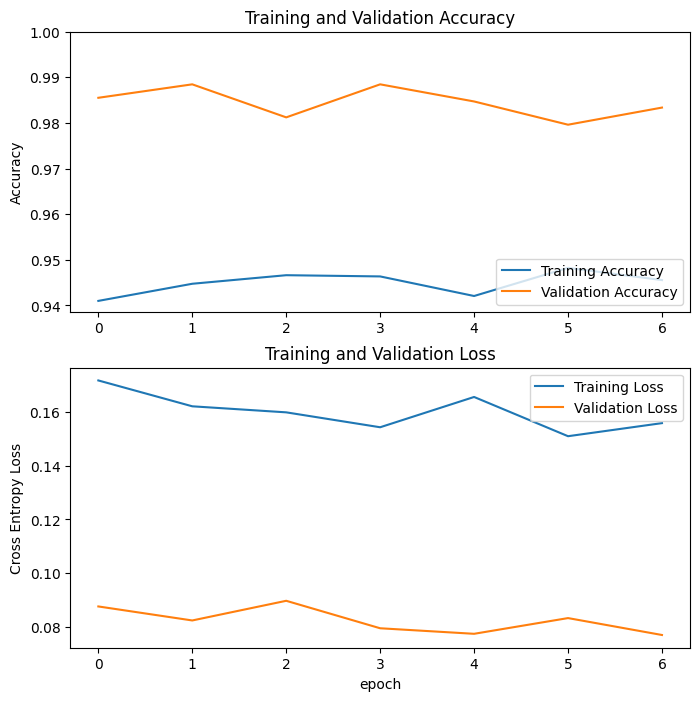

In [ ]:
# Visualize the learning curve

# Accuracies

train_acc_list = history.history['accuracy']
val_acc_list = history.history['val_accuracy']

plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(train_acc_list, label = 'Training Accuracy')
plt.plot(val_acc_list, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Losses

train_loss_list = history.history['loss']
val_loss_list = history.history['val_loss']

plt.subplot(2,1,2)
plt.plot(train_loss_list, label = 'Training Loss')
plt.plot(val_loss_list, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
# testing

test_pred_labels = model.predict(test_df)

threshold = 0.5
test_pred_labels = (test_pred_labels > threshold).astype(int)
test_labels = []
for images, labels in test_df:
  for label in labels:
    test_labels.append(label)
test_labels = np.array(test_labels)

# convert one-hot to labels
test_pred_labels = np.argmax(test_pred_labels, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_pred_labels)
print("Test Accuracy:", test_accuracy)

# Calculate macro F1 score (micro will be same as accuracy since it is multi-class and not multi-label classification)
test_f1 = f1_score(test_labels, test_pred_labels, average='macro')
print("Test F1 Score (macro):", test_f1)
print('-' * 15)
# Additional:

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_pred_labels)
print("Confusion Matrix:\n", conf_matrix)
print('-' * 15)
# Classification report
class_report = classification_report(test_labels, test_pred_labels)
print("Classification Report:\n", class_report)
print('-' * 15)


25/25 [==============================] - 2s 40ms/step
Test Accuracy: 0.84
Test F1 Score (macro): 0.8339493856287788
---------------
Confusion Matrix:
 [[125   7   1   0   9   0]
 [ 10  91  12   5   2   2]
 [  4   4  85  10   3   0]
 [  9   1  14 178   2   1]
 [ 15   5   6   2  80   0]
 [  1   0   1   2   0 113]]
---------------
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.82       142
           1       0.84      0.75      0.79       122
           2       0.71      0.80      0.76       106
           3       0.90      0.87      0.89       205
           4       0.83      0.74      0.78       108
           5       0.97      0.97      0.97       117

    accuracy                           0.84       800
   macro avg       0.84      0.83      0.83       800
weighted avg       0.84      0.84      0.84       800

---------------


First model report:

```
Train Accuracy: 0.9444891214370728
Validation Accuracy: 0.9865915775299072
Train Loss: 0.16843244433403015
Validation Loss: 0.08771998435258865

Validation F1 Score (macro): 0.9796797087654346
---------------
Confusion Matrix:
 [[674   1   2   0   3   0]
 [ 13 528   3   1   0   0]
 [ 13   1 519   3   2   0]
 [ 12   0   3 878   2   0]
 [ 10   1   4   1 479   0]
 [  0   0   0   0   0 576]]
---------------
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       680
           1       0.99      0.97      0.98       545
           2       0.98      0.96      0.97       538
           3       0.99      0.98      0.99       895
           4       0.99      0.97      0.98       495
           5       1.00      1.00      1.00       576

    accuracy                           0.98      3729
   macro avg       0.98      0.98      0.98      3729
weighted avg       0.98      0.98      0.98      3729

---------------

Test Accuracy: 0.84
Test F1 Score (macro): 0.8328031093763273
---------------
Confusion Matrix:
 [[125   7   1   0   9   0]
 [ 13  89  11   5   2   2]
 [  3   5  82  11   4   1]
 [  7   0  14 181   3   0]
 [ 14   4   6   1  83   0]
 [  2   0   1   2   0 112]]
---------------
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.82       142
           1       0.85      0.73      0.78       122
           2       0.71      0.77      0.74       106
           3       0.91      0.88      0.89       205
           4       0.82      0.77      0.79       108
           5       0.97      0.96      0.97       117

    accuracy                           0.84       800
   macro avg       0.84      0.83      0.83       800
weighted avg       0.84      0.84      0.84       800

---------------





### Modify:


####1.

We rerun the above cells from 'Model' section till 'Evaluate' section but this time while also training the last 2 layers of the base model. This makes up our second model.

Second model report:

```
Train Accuracy: 0.9447572827339172
Validation Accuracy: 0.9884687662124634
Train Loss: 0.1622653752565384
Validation Loss: 0.08226525038480759

Validation F1 Score (macro): 0.9838134895955094
---------------
Confusion Matrix:
 [[675   1   2   0   2   0]
 [  8 534   2   1   0   0]
 [  6   2 529   1   0   0]
 [  5   1   5 884   0   0]
 [ 13   1   7   1 473   0]
 [  0   0   0   0   0 576]]
---------------
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       680
           1       0.99      0.98      0.99       545
           2       0.97      0.98      0.98       538
           3       1.00      0.99      0.99       895
           4       1.00      0.96      0.98       495
           5       1.00      1.00      1.00       576

    accuracy                           0.98      3729
   macro avg       0.98      0.98      0.98      3729
weighted avg       0.98      0.98      0.98      3729

---------------

Test Accuracy: 0.84
Test F1 Score (macro): 0.8339493856287788
---------------
Confusion Matrix:
 [[125   7   1   0   9   0]
 [ 10  91  12   5   2   2]
 [  4   4  85  10   3   0]
 [  9   1  14 178   2   1]
 [ 15   5   6   2  80   0]
 [  1   0   1   2   0 113]]
---------------
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.82       142
           1       0.84      0.75      0.79       122
           2       0.71      0.80      0.76       106
           3       0.90      0.87      0.89       205
           4       0.83      0.74      0.78       108
           5       0.97      0.97      0.97       117

    accuracy                           0.84       800
   macro avg       0.84      0.83      0.83       800
weighted avg       0.84      0.84      0.84       800

---------------


###Results:

The reports of the first and second model show almost same values for the
various metrics, despite also training last year layers of the base model. This suggests that the model has possibly reached its limit. Also, the accuracies and F1 scores seem pretty good for a small dataset as this.

Usually the augmented data is added as new samples in trainset, especially in case of smaller datasets. However, since the training and validation scores are high with test scores pretty good I choose to not do it. The classification task is pretty simple and the noise added could possibly decrease the scores.

